In [1]:
%run init_notebook.py

In [2]:
from src.utils import *
from src.processing import pd_join_dfs, pd_groupby, xcorr
from src.statsmodels import *
import scipy

In [3]:
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ValueWarning)

In [4]:
from src.utils import load_pd_df, save_pd_df, get_dt_index, pd_join_freq, Capturing, cross_corr, pd_df_astype, save_fig, get_stars
from src.processing import pd_groupby, pd_join_dfs, adf_test_summary, hausman, plt_stacked_bar, get_individual_perc_error
from src.pymc_modelling import get_samp

from statsmodels.stats.diagnostic import het_white, het_breuschpagan
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson

from linearmodels.panel import PanelOLS
from linearmodels import RandomEffects
from statsmodels.iolib.summary2 import summary_col

In [221]:
df_micro = load_pd_df("df_analysis_micro.feather")
df = load_pd_df("df_analysis.feather")
dict_fe_test_res = {}

In [222]:
DICT_PARSE_COLS.update(
    {
        'T_pca_sum': float,
        'T_pca_sum_diff': float,
        'pi_de_surprise_Y': float,
        'pi_de_estimate_Y': float,
        'delta_pe_error': float,
        'hhinc_midpoint': 'categoryO',
        'T_sum_raw': float,
        'T_sum_glob': float,
        'T_sum_glob_op3': float,
        'T_sum_glob_op5': float,
        'T_sum_ind_op': float,
        'T_sum_ind_op_all': float,
        'T_sum_ind': float,
        'T_sum_raw_diff': float,
        'T_sum_glob_diff': float,
        'T_sum_ind_op_diff': float,
        'T_sum_ind_op_all_diff': float,
        'T_sum_ind_diff': float,
        'T_sum_glob_op3_diff': float,
        'T_sum_glob_op5_diff': float,
        'pi_de_Y_diff_F': float,
        'ecbtrust': float,
        'pi_de_Y_lead1': float,
        'pi_de_estimate_Y_lead1': float,
        'pi_de_surprise_Y_lead1': float,
    }
)

In [223]:
df_micro = pd_df_astype(df_micro, DICT_PARSE_COLS)

## panel structure sparsity and distance analysis

In [224]:
filt = df_micro.groupby(['id', 'week_recorded']).pi_perc.last().unstack().count(axis=1)
# filt.describe()

In [225]:
sub = df_micro.set_index('id').loc[filt[filt > 1].index].reset_index().groupby(['id', 'week_recorded']).last()
sub = sub[
    ['hhinc_midpoint', 'pi_perc_error', 'delta_pe_error', 'debt', 'wealth_bank', 'savings_planned', 'ecbtrust', 'hhsize']
]

In [226]:
filt = sub.reset_index().groupby(['id', 'week_recorded']).delta_pe_error.last().unstack().count(axis=1)
# filt.describe()

In [227]:
dist = sub.reset_index().groupby('id').last().drop('week_recorded', axis=1).astype(float)
dist['distance'] = scipy.spatial.distance.cdist(dist.fillna(0).values, dist.fillna(0).values).mean(axis=0)
dist['distance'] = min_max_scale(dist.distance)

<AxesSubplot: xlabel='week_recorded', ylabel='id'>

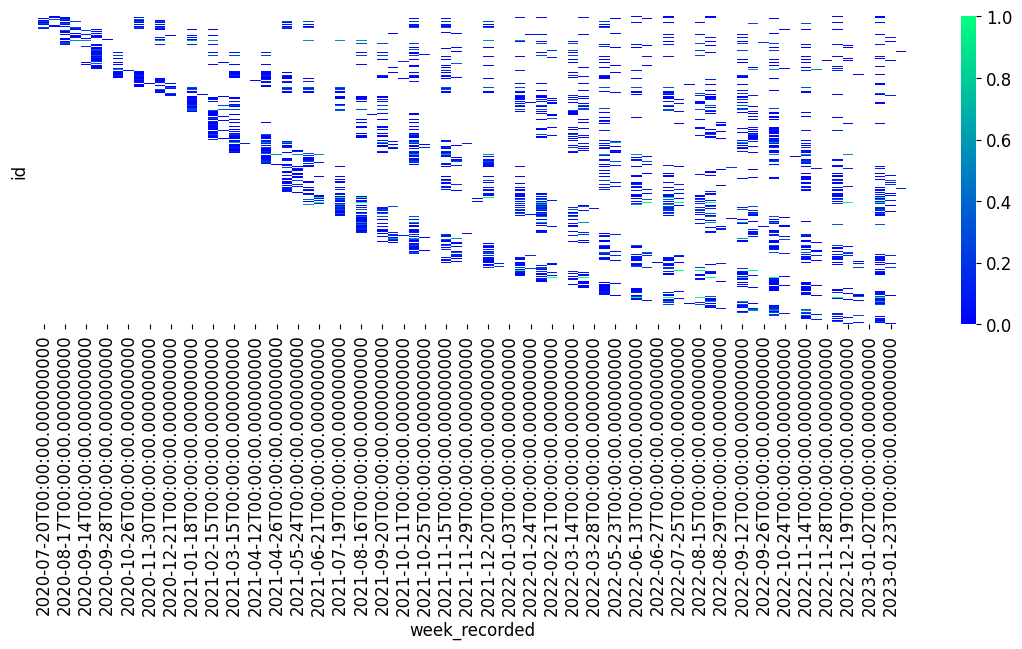

In [228]:
sns.heatmap(
    sub.reset_index().set_index('id').join(dist.distance).reset_index().set_index(['id', 'week_recorded']).distance.unstack(),
    cmap='winter',
    yticklabels=False,
)

In [229]:
def pols_get_test_res(mod_fe, mod_re, sub, cols, sig: float = .05, seperator: str = "\n"):
    res = {}
    
    # H0: Homoscedasticity is present
    _ = sm.add_constant(pd.concat([mod_fe.resids, sub[cols]], axis=1))
    res['Breusch Pagan Test'] = dict(zip(
        ['LM-Stat', 'LM p-val', 'stat', 'pval'],
        het_breuschpagan(_[['residual']], _.drop('residual', axis=1))
    ))
    
    # Durbin watson
    res['Durbin-Watson Test'] = {'stat':durbin_watson(mod_fe.resids)}
    
    # Haussman H0: RE is to be preferred
    res['Hausmann Test'] = dict(zip(['stat', 'df', 'pval'], hausman(mod_fe, mod_re)))
    
    df = pd.DataFrame(res).T
    df['coef'] = df.pval <= sig
    df['star'] = df.pval.apply(lambda x: get_stars(x))
    df['print'] = df.coef.astype(str) + " " + df.star.astype(str) + seperator + "[" + df.stat.round(3).astype(str) + "]"
    df.loc['Durbin-Watson Test', 'print'] = df.loc['Durbin-Watson Test', 'stat'].round(3).astype(str)
    
    return df

## pi perc

In [230]:
cols = ['T_sum_ind_diff', 'hhinc_midpoint', 'pi_de_surprise_Y', 'pi_de_estimate_Y'] #, 'debt',]
ind_cols = ['id', 'week_recorded']
dep_col = ['pi_perc']

In [231]:
filt = df_micro.groupby(ind_cols)[dep_col].last().dropna().unstack().count(axis=1)
# filt.describe()

In [232]:
i = 6
sub = df_micro.set_index('id').loc[filt[filt > i].index].reset_index().groupby(ind_cols).last()
sub = sub[cols + dep_col].dropna()

In [233]:
filt = sub.reset_index().groupby(ind_cols)[dep_col].last().unstack().count(axis=1)
# filt.describe()

In [234]:
sub.shape, filt.sum()

((1132, 5), 1132)

In [235]:
m_fe11 = PanelOLS(sub[dep_col], sub[cols], entity_effects=True, ).fit(cov_type='clustered', cluster_entity=True)
m_re = RandomEffects(sub[dep_col], sub[cols]).fit()

In [236]:
dist, filt = get_cooks_distance(sub[cols].values.astype(float), m_fe11.resids.values, flt_largest_perc=90.)
sub2 = sub.drop(sub.loc[filt].index.get_level_values(0))
m_fe1_ = PanelOLS(sub2[dep_col], sub2[cols],
                   entity_effects=True, drop_absorbed=True, check_rank=False).fit(cov_type="clustered", cluster_entity=True)

C:\Users\LukasGrahl\AppData\Local\Temp\ipykernel_30800\3440417660.py:4: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

hhinc_midpoint.750.0, hhinc_midpoint.12000.0

  entity_effects=True, drop_absorbed=True, check_rank=False).fit(cov_type="clustered", cluster_entity=True)


In [237]:
out = get_statsmodels_summary([m_fe11, m_fe1_], ['print'], seperator=" ", is_filt_sig=False)
out

print                     
                                    pi_perc            pi_perc_1
hhinc_midpoint.2250.0        0.001  [0.078]     -0.006  [-1.284]
hhinc_midpoint.9000.0       0.006 * [1.758]    0.006 *** [2.876]
hhinc_midpoint.750.0        -0.01  [-1.408]                  NaN
hhinc_midpoint.7000.0   -0.007 *** [-4.569]  -0.007 *** [-7.987]
hhinc_midpoint.5500.0    -0.009 *** [-2.65]  -0.012 *** [-7.475]
hhinc_midpoint.4250.0      -0.003  [-0.608]  -0.008 *** [-3.525]
hhinc_midpoint.3750.0      -0.007  [-1.282]  -0.009 *** [-3.076]
hhinc_midpoint.3250.0      -0.01 * [-1.737]  -0.012 *** [-3.762]
hhinc_midpoint.2750.0      -0.009  [-1.345]    -0.01 ** [-2.383]
pi_de_estimate_Y         1.356 *** [26.622]    1.46 *** [41.486]
pi_de_surprise_Y         -0.187 ** [-2.199]  -0.222 *** [-4.069]
hhinc_midpoint.1250.0      -0.006  [-0.554]          0.0  [0.01]
hhinc_midpoint.12000.0    0.012 *** [4.419]                  NaN
T_sum_ind_diff              -0.01  [-0.491]     -0.015  [-0.949]
hhinc_midpoint.1750.0      -0.006  [-0.592]     -0.01 * [-1.903]
R^2 between                           0.858                0.872
R^2                                   0.689                0.883
N time                                 37.0                 32.0
N entity                              165.0                104.0
N                                    1132.0                711.0
Entity effects                          1.0                  1.0

In [238]:
name, i = dep_col[0], 1
while (name in dict_fe_test_res.keys()) == True:
    name += str(i)
dict_fe_test_res[name] = pols_get_test_res(m_fe11, m_re, sub, cols)['print']

## pi perc 2

In [239]:
cols = ['T_sum_ind_diff', 'hhinc_midpoint', 'pi_de_surprise_Y_lead1', 'pi_de_estimate_Y_lead1'] #, 'debt',]
ind_cols = ['id', 'week_recorded']
dep_col = ['pi_perc']

In [240]:
filt = df_micro.groupby(ind_cols)[dep_col].last().dropna().unstack().count(axis=1)
# filt.describe()

In [241]:
i = 6
sub = df_micro.set_index('id').loc[filt[filt > i].index].reset_index().groupby(ind_cols).last()
sub = sub[cols + dep_col].dropna()

In [242]:
filt = sub.reset_index().groupby(ind_cols)[dep_col].last().unstack().count(axis=1)
# filt.describe()

In [243]:
sub.shape, filt.sum()

((1132, 5), 1132)

In [244]:
m_fe12 = PanelOLS(sub[dep_col], sub[cols], entity_effects=True, ).fit(cov_type='clustered', cluster_entity=True)
m_re = RandomEffects(sub[dep_col], sub[cols]).fit()

In [245]:
dist, filt = get_cooks_distance(sub[cols].values.astype(float), m_fe12.resids.values, flt_largest_perc=90.)
sub2 = sub.drop(sub.loc[filt].index.get_level_values(0))
m_fe_ = PanelOLS(sub2[dep_col], sub2[cols],
                   entity_effects=True, drop_absorbed=True, check_rank=False).fit(cov_type="clustered", cluster_entity=True)

C:\Users\LukasGrahl\AppData\Local\Temp\ipykernel_30800\1443597657.py:4: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

hhinc_midpoint.750.0, hhinc_midpoint.12000.0

  entity_effects=True, drop_absorbed=True, check_rank=False).fit(cov_type="clustered", cluster_entity=True)


In [246]:
out = get_statsmodels_summary([m_fe12, m_fe_], ['print'], seperator=" ", is_filt_sig=False)
# out

In [247]:
name, i = dep_col[0], 1
while (name in dict_fe_test_res.keys()) == True:
    name += str(i)
dict_fe_test_res[name] = pols_get_test_res(m_fe12, m_re, sub, cols)['print']

## delta pe 1

In [248]:
cols = ['T_sum_ind_diff', 'hhinc_midpoint', 'pi_de_surprise_Y', 'pi_de_estimate_Y', 'is_unempl'] #, 'is_unempl', 'wealth_bank',]  #'debt',]
ind_cols = ['id', 'week_recorded']
dep_col = ['delta_pe']

In [249]:
filt = df_micro.groupby(ind_cols)[dep_col].last().dropna().unstack().count(axis=1)
# filt.describe()

In [250]:
i = 11
sub = df_micro.set_index('id').loc[filt[filt > i].index].reset_index().groupby(ind_cols).last()
sub = sub[cols + dep_col].dropna()

In [251]:
filt = sub.reset_index().groupby(ind_cols)[dep_col].last().unstack().count(axis=1)
# filt.describe()

In [252]:
sub.shape, filt.sum()

((3525, 6), 3525)

In [253]:
m_fe2 = PanelOLS(sub[dep_col], sub[cols], entity_effects=True).fit(cov_type='clustered', cluster_entity=True)
m_re = RandomEffects(sub[dep_col], sub[cols]).fit()

In [254]:
name, i = dep_col[0], 1
while (name in dict_fe_test_res.keys()) == True:
    name += str(i)
dict_fe_test_res[name] = pols_get_test_res(m_fe2, m_re, sub, cols)['print']

## pi perc resid

In [255]:
cols = ['T_sum_ind_diff', 'hhinc_midpoint', 'pi_de_surprise_Y', 'pi_de_estimate_Y',] # 'is_unempl' ] #'debt', 'is_unempl', 'wealth_bank',]  #'debt',]
ind_cols = ['id', 'week_recorded']
dep_col = ['pi_perc_error']

In [256]:
filt = df_micro.groupby(ind_cols)[dep_col].last().dropna().unstack().count(axis=1)
# filt.describe()

In [257]:
i = 6
sub = df_micro.set_index('id').loc[filt[filt > i].index].reset_index().groupby(ind_cols).last()
sub = sub[cols + dep_col].dropna()

In [258]:
filt = sub.reset_index().groupby(ind_cols)[dep_col].last().unstack().count(axis=1)
# filt.describe()

In [259]:
sub.shape, filt.sum()

((1132, 5), 1132)

In [260]:
m_fe41 = PanelOLS(sub[dep_col], sub[cols], entity_effects=True).fit(cov_type='clustered', cluster_entity=True)
m_re = RandomEffects(sub[dep_col], sub[cols]).fit()
# m_fe4.summary

In [261]:
name, i = dep_col[0], 1
while (name in dict_fe_test_res.keys()) == True:
    name += str(i)
dict_fe_test_res[name] = pols_get_test_res(m_fe41, m_re, sub, cols)['print']

## pi perc resid 2

In [262]:
cols = ['T_sum_ind_diff', 'pi_de_surprise_Y_lead1', 'pi_de_estimate_Y_lead1', 'hhinc_midpoint',] # 'is_unempl' ] #'debt', 'is_unempl', 'wealth_bank',]  #'debt',]
ind_cols = ['id', 'week_recorded']
dep_col = ['pi_perc_error']

In [263]:
filt = df_micro.groupby(ind_cols)[dep_col].last().dropna().unstack().count(axis=1)
# filt.describe()

In [264]:
i = 6
sub = df_micro.set_index('id').loc[filt[filt > i].index].reset_index().groupby(ind_cols).last()
sub = sub[cols + dep_col].dropna()

In [265]:
filt = sub.reset_index().groupby(ind_cols)[dep_col].last().unstack().count(axis=1)
# filt.describe()

In [266]:
sub.shape, filt.sum()

((1132, 5), 1132)

In [267]:
m_fe42 = PanelOLS(sub[dep_col], sub[cols], entity_effects=True).fit(cov_type='clustered', cluster_entity=True)
m_re = RandomEffects(sub[dep_col], sub[cols]).fit()
# m_fe4.summary

In [268]:
name, i = dep_col[0], 1
while (name in dict_fe_test_res.keys()) == True:
    name += str(i)
dict_fe_test_res[name] = pols_get_test_res(m_fe42, m_re, sub, cols)['print']

## delta pe resid

In [269]:
cols = ['T_sum_ind_diff', 'pi_de_surprise_Y', 'pi_de_estimate_Y', 'hhinc_midpoint', 'is_unempl', ] #'wealth_bank',]  #'debt',]
ind_cols = ['id', 'week_recorded']
dep_col = ['delta_pe_error']

In [270]:
filt = df_micro.groupby(ind_cols)[dep_col].last().dropna().unstack().count(axis=1)
# filt.describe()

In [271]:
i = 10
sub = df_micro.set_index('id').loc[filt[filt > i].index].reset_index().groupby(ind_cols).last()
sub = sub[cols + dep_col].dropna()

In [272]:
filt = sub.reset_index().groupby(ind_cols)[dep_col].last().unstack().count(axis=1)
# filt.describe()

In [273]:
sub.shape, filt.sum()

((13925, 6), 13925)

In [274]:
m_fe5 = PanelOLS(sub[dep_col], sub[cols], entity_effects=True).fit(cov_type='clustered', cluster_entity=True)
m_re = RandomEffects(sub[dep_col], sub[cols]).fit()
# print(m_fe5)

In [275]:
name, i = dep_col[0], 1
while (name in dict_fe_test_res.keys()) == True:
    name += str(i)
dict_fe_test_res[name] = pols_get_test_res(m_fe5, m_re, sub, cols)['print']

## summary

In [276]:
lst_fes = [m_fe11, m_fe12, m_fe2, m_fe3, m_fe41, m_fe42, m_fe5]
out = get_statsmodels_summary(lst_fes, seperator=" ", is_filt_sig=False)
save_pd_df(out, 'tab_pols.csv', GRAPHS_DIR)

In [277]:
out.sort_index(ascending=False)

,delta_pe,delta_pe_error,pi_exp,pi_perc,pi_perc_1,pi_perc_error,pi_perc_error_5
pi_de_surprise_Y_lead1,NaN,NaN,NaN,NaN,-0.086 [-1.226],NaN,-1.147 *** [-16.389]
pi_de_surprise_Y,-0.597 *** [-80.363],-1.068 *** [-65.647],0.411 *** [9.999],-0.187 ** [-2.199],NaN,-0.656 *** [-7.04],NaN
pi_de_estimate_Y_lead1,NaN,NaN,NaN,NaN,1.24 *** [29.274],NaN,0.233 *** [5.598]
pi_de_estimate_Y,0.457 *** [83.334],3.241 *** [149.17],0.736 *** [22.996],1.356 *** [26.622],NaN,-0.037 [-0.669],NaN
is_unempl,-0.001 [-0.858],-0.001 [-0.291],NaN,NaN,NaN,NaN,NaN
hhinc_midpoint.9000.0,0.001 [0.683],-0.001 [-0.168],-0.022 *** [-2.942],0.006 * [1.758],0.002 [0.668],0.007 ** [2.138],0.002 [0.456]
hhinc_midpoint.750.0,-0.001 [-1.471],-0.005 [-1.196],-0.016 ** [-2.127],-0.01 [-1.408],-0.011 [-1.624],-0.017 ** [-2.336],-0.012 * [-1.788]
hhinc_midpoint.7000.0,-0.001 [-0.952],-0.005 [-1.019],-0.018 *** [-2.604],-0.007 *** [-4.569],-0.009 *** [-6.98],-0.007 *** [-4.676],-0.01 *** [-7.328]
hhinc_midpoint.5500.0,-0.001 [-0.73],-0.003 [-0.673],-0.016 ** [-2.31],-0.009 *** [-2.65],-0.012 *** [-3.59],-0.01 *** [-2.853],-0.012 *** [-3.708]
hhinc_midpoint.4250.0,-0.001 [-0.813],-0.003 [-0.666],-0.016 ** [-2.367],-0.003 [-0.608],-0.005 [-0.959],-0.005 [-0.968],-0.006 [-1.058]


In [284]:
dict_fe_test_res['pi_perc']

Breusch Pagan Test      False \n[0.505]
Durbin-Watson Test                1.858
Hausmann Test         False \n[-17.463]
Name: print, dtype: object

In [285]:
out = pd.DataFrame(dict_fe_test_res).T.sort_index()
save_pd_df(out, 'tab_pols_tests.csv')

In [282]:
out

,Breusch Pagan Test,Durbin-Watson Test,Hausmann Test
delta_pe,True ***\n[118.349],1.694,True ***\n[33.95]
delta_pe_error,True ***\n[81.846],1.056,True ***\n[597.559]
pi_perc,False \n[0.505],1.858,False \n[-17.463]
pi_perc1,False \n[0.202],1.874,True ***\n[178.502]
pi_perc_error,False \n[0.912],1.932,False \n[-44.579]
pi_perc_error1,False \n[0.212],1.873,True ***\n[2640.426]
